In [58]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import numpy as np
import ray
from ray.rllib import agents
from tqdm.notebook import tqdm
import random
from ray.rllib.policy.policy import Policy
from gym.spaces import Discrete, Box
from ray.rllib.agents.ppo import PPOTrainer
from functools import partial
from ray.tune.registry import register_env, _global_registry, ENV_CREATOR
from ray.tune.logger import pretty_print
from ray.rllib.agents.ppo.ppo_tf_policy import PPOTFPolicy
from ray.rllib.models import ModelCatalog


import ray
from ray import tune
from ray.tune import track

import math
import gym

from gym_compete_to_rllib import GymCompeteToRLLibAdapter

from ray.rllib.models.tf.tf_modelv2 import TFModelV2

from load_gym_compete_policy import get_policy_value_nets
from ray.tune.registry import register_env

from ray.rllib.models.tf.tf_action_dist import DiagGaussian 
import datetime, uuid

In [29]:
class KerasModelModel(TFModelV2):
    """Create an RLLib policy from policy+value keras models."""
    def __init__(self, *args, policy_net=None, value_net=None, **kwargs):
        super(KerasModelModel, self).__init__(*args, **kwargs)
        self.policy_net = policy_net
        self.value_net = value_net
        self.register_variables(policy_net.variables + value_net.variables)
        
    def forward(self, input_dict, state, seq_lens):
        obs = input_dict["obs"]
        model_out = self.policy_net(obs)
        self._value_out = self.value_net(obs)
        #if obs.shape[0] == 1:
        self._value_out = self._value_out[0]
        return model_out, state
    
    def value_function(self):
        return self._value_out
    
class GymCompetePretrainedModel(KerasModelModel):
    """Load a policy from gym_compete."""
    def __init__(self, *args, **kwargs):
        env_name = args[3]['custom_model_config']['env_name']
        agent_id = args[3]['custom_model_config']['agent_id']
        nets = get_policy_value_nets(env_name, agent_id)
        n_out = int(nets['policy_mean_logstd_flat'].output_shape[1])
        super(GymCompetePretrainedModel, self).__init__(*args, **kwargs,
                                                        policy_net=nets['policy_mean_logstd_flat'],
                                                        value_net=nets['value'])


In [69]:
str(datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '-' + str(uuid.uuid1()))

'20200716-200052-498f98ec-c78e-11ea-a543-00155d2cc007'

In [30]:
ModelCatalog.register_custom_model("GymCompetePretrainedModel", GymCompetePretrainedModel)
ModelCatalog.register_custom_action_dist("DiagGaussian", DiagGaussian)

In [70]:
def gym_compete_env_with_video(env_name, directory=None):
    """Record videos from gym_compete environments using aprl."""
    
    # hacks to make it work with tf2
    import sys
    from unittest.mock import Mock
    sys.modules['stable_baselines'] = Mock()
    import tensorflow as tf
    tf.Session = Mock()
    
    if directory is None:
        directory = 'video-' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '-' + str(uuid.uuid1())

    from aprl.envs.wrappers import VideoWrapper
    from aprl.visualize.annotated_gym_compete import AnnotatedGymCompete
    from aprl.score_agent import default_score_config

    config = default_score_config()
    env = gym.make(env_name)
    config

    env = AnnotatedGymCompete(env=env, env_name=env_name, agent_a_type=config['agent_a_type'], agent_b_type=config['agent_b_type'],
                        agent_a_path=config['agent_a_path'], agent_b_path=config['agent_b_path'],
                        mask_agent_index=config['mask_agent_index'], resolution=config['video_params']['annotation_params']['resolution'],
                        font=config['video_params']['annotation_params']['font'], font_size=config['video_params']['annotation_params']['font_size'],
                        short_labels=config['video_params']['annotation_params']['short_labels'], camera_config=config['video_params']['annotation_params']['camera_config']
    )

    env = VideoWrapper(env=env, directory=directory)

    return env

In [71]:
env_config = {}
env_name = 'multicomp/YouShallNotPassHumans-v0'
env_name_rllib = env_name.split('/')[1] + '_rllib'
def create_env(config=None, env_name=env_name):
    #env = gym.make(env_name)
    env = gym_compete_env_with_video(env_name)
    return GymCompeteToRLLibAdapter(lambda: env)
register_env(env_name_rllib, create_env)
env_cls = create_env


def build_trainer_config(restore_state=None, train_policies=None, config=None):
    """Build configuration for 1 run."""
    obs_space = env_cls(env_config).observation_space
    act_space = env_cls(env_config).action_space

    policy_template = "player_%d"

    def get_agent_config(agent_id):
        agent_config = (PPOTFPolicy, obs_space, act_space, {
            'model': {
                        "custom_model": "GymCompetePretrainedModel",
                        "custom_model_config": {
                            "agent_id": agent_id - 1,
                            "env_name": env_name,
                            "model_config": {},
                            "name": "model_%s" % (agent_id - 1)
                        },           
                        
                    },
            
            "framework": "tfe",
        })
        
        return agent_config
        
        agent_config = (PPOTFPolicy, obs_space, act_space, {
                    "model": {
                        "use_lstm": False,
                        "fcnet_hiddens": [64, 64],
                        #"custom_action_dist": "DiagGaussian",
                    },
                    "framework": "tfe",
                })
        
        return agent_config

    N_POLICIES = 2

    policies = {policy_template % i: get_agent_config(i) for i in range(1, 1  + N_POLICIES)}
    policies_keys = list(sorted(policies.keys()))

    def select_policy(agent_id):
        assert agent_id in ["player_1", "player_2"]
        agent_ids = ["player_1", "player_2"]
        
        # selecting the corresponding policy (only for 2 policies)
        return policies_keys[agent_ids.index(agent_id)]

        # randomly choosing an opponent
        # return np.random.choice(list(policies.keys()))
    
    if train_policies is None:
        train_policies = list(policies.keys())
        
    for k in train_policies:
        assert k in policies.keys()

    config = {
        "env": env_name_rllib,
    #    "gamma": 0.9,
      "num_workers": 0,
    #  "num_envs_per_worker": 10,
    #   "rollout_fragment_length": 10,
       "train_batch_size": config['train_batch_size'],
        "multiagent": {
            "policies_to_train": train_policies,
            "policies": policies,
            "policy_mapping_fn": select_policy,
        },
        "framework": "tfe",
        #"train_batch_size": 512
        #"num_cpus_per_worker": 2
    }
    return config


def build_trainer(restore_state=None, train_policies=None, config=None):
    """Create a RPS trainer for 2 agents, restore state, and only train specific policies."""
    
    print("Using config")
    print(config)
    cls = PPOTrainer
    trainer = cls(config=config)
    env = trainer.workers.local_worker().env
    if restore_state is not None:
        trainer.restore_from_object(restore_state)
    return trainer

def train(trainer, stop_iters, do_track=True):
    """Train the agents and return the state of the trainer."""
    for _ in range(stop_iters):
        results = trainer.train()
        print(pretty_print(results))
        if do_track:
            track.log(**results)
    o = trainer.save_to_object()
    return o

trainer = None

def train_one(config, restore_state=None, do_track=True):
    print(config)
    rl_config = build_trainer_config(restore_state=restore_state,
                              train_policies=config['train_policies'],
                              config=config)
    global trainer
    trainer = build_trainer(restore_state=None, config=rl_config)
    train(trainer, config['train_steps'], do_track=do_track)


# try changing learning rate
config = {'train_batch_size': 128}

config['train_steps'] = 3
config['train_policies'] = ['player_1', 'player_2']
config['num_workers'] = 3

In [72]:
train_one(config, do_track=False)

{'train_batch_size': 128, 'train_steps': 3, 'train_policies': ['player_1', 'player_2'], 'num_workers': 3}
Creating agent humanoid_blocker
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents
Creating agent humanoid_blocker
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents


pip install 'ray[tune]' to see TensorBoard files.
Could not instantiate TBXLogger: No module named 'tensorboardX'.


Using config
{'env': 'YouShallNotPassHumans-v0_rllib', 'num_workers': 0, 'train_batch_size': 128, 'multiagent': {'policies_to_train': ['player_1', 'player_2'], 'policies': {'player_1': (<class 'ray.rllib.policy.tf_policy_template.PPOTFPolicy'>, Box(380,), Box(17,), {'model': {'custom_model': 'GymCompetePretrainedModel', 'custom_model_config': {'agent_id': 0, 'env_name': 'multicomp/YouShallNotPassHumans-v0', 'model_config': {}, 'name': 'model_0'}}, 'framework': 'tfe'}), 'player_2': (<class 'ray.rllib.policy.tf_policy_template.PPOTFPolicy'>, Box(380,), Box(17,), {'model': {'custom_model': 'GymCompetePretrainedModel', 'custom_model_config': {'agent_id': 1, 'env_name': 'multicomp/YouShallNotPassHumans-v0', 'model_config': {}, 'name': 'model_1'}}, 'framework': 'tfe'})}, 'policy_mapping_fn': <function build_trainer_config.<locals>.select_policy at 0x7f73fc501d30>}, 'framework': 'tfe'}
Creating agent humanoid_blocker
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_com

Install gputil for GPU system monitoring.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for

In [49]:
from matplotlib import pyplot as plt

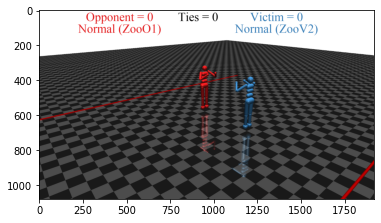

In [50]:
plt.imshow(env.render(mode='rgb_array')) 

In [51]:
env.action_space

Tuple(Box(17,), Box(17,))

In [14]:
!pip install sacred

Processing /home/sergei/.cache/pip/wheels/f6/45/a9/14c44d91b89477407934233a99afe6414cf5607adfc39bd5fb/sacred-0.8.1-py2.py3-none-any.whl
     |████████████████████████████████| 95 kB 637 kB/s eta 0:00:01
Processing /home/sergei/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c/docopt-0.6.2-py2.py3-none-any.whl
  Using cached jsonpickle-1.4.1-py2.py3-none-any.whl (36 kB)
     |████████████████████████████████| 158 kB 12.7 MB/s eta 0:00:01
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Using cached importlib_metadata-1.7.0-py2.py3-none-any.whl (31 kB)
  Using cached gitdb-4.0.5-py3-none-any.whl (63 kB)
  Using cached zipp-3.1.0-py3-none-any.whl (4.9 kB)
  Using cached smmap-3.0.4-py2.py3-none-any.whl (25 kB)
  Created wheel for py-cpuinfo: filename=py_cpuinfo-7.0.0-py3-none-any.whl size=20068 sha256=bc34e8b0c05fed2db1fa4c2f9159735441d44347e9c2e49a69e45892135e42f6
  Stored in directory: /home/sergei/.cache/pip/wheels/b4/99/9f/8eb77fdf759c1380719071722

In [ ]:
if video_params["annotated"]:
    if "multicomp" in env_name:
        assert num_env == 1, "pretty videos requires num_env=1"
        env = AnnotatedGymCompete(
            env,
            env_name,
            agent_a_type,
            agent_a_path,
            agent_b_type,
            agent_b_path,
            mask_agent_index,
            **video_params["annotation_params"],
        )
    else:
        warnings.warn(f"Annotated videos not supported for environment '{env_name}'")
env = VideoWrapper(env, video_dirs[i], video_params["single_file"])
return env
